# Tuning Neural Networks with Regularization - Lab

## Introduction

Recall from the last lab that you had a training accuracy close to 90% and a test set accuracy close to 76%.

As with your previous machine learning work, you should be asking a couple of questions:
- Is there high bias? yes/no
- Is there high variance? yes/no 

In this lab, you'll use the a train-validate-test partition as well as a validation set to get better insights of how to tune neural networks using regularization techniques. You'll start by repeating the process from the last section: importing the data and performing preprocessing including one-hot encoding. From there, you'll define and compile the model like before. However, this time, when you are presented with the `history` dictionary of the model, you will have additional data entries for not only the train and test set but also the validation set.

## Objectives

You will be able to:

* Construct and run a basic model in Keras
* Construct a validation set and explain potential benefits
* Apply L1 and L2 regularization
* Apply dropout regularization
* Observe and comment on the effect of using more data

## Import the libraries

As usual, start by importing some of the packages and modules that you intend to use. The first thing you'll be doing is importing the data and taking a random sample, so that should clue you in to what tools to import. If you need more tools down the line, you can always import additional packages later.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
import random
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers

Using TensorFlow backend.


## Load the Data

As with the previous lab, the data is stored in a file **Bank_complaints.csv**. Load and preview the dataset.

In [2]:
df=pd.read_csv('Bank_complaints.csv')
df.head()

,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


## Preprocessing Overview

Before you begin to practice some of your new tools regarding regularization and optimization, let's practice munging some data as you did in the previous section with bank complaints. Recall some techniques:

* Train - test split
* Sampling in order to reduce training time (investigate model accuracy vs data size later on)
* One-hot encoding your complaint text
* Transforming your category labels

## Preprocessing: Generate a Random Sample

Since you have quite a bit of data and training networks takes a substantial amount of time and resources, downsample in order to test your initial pipeline. Going forward, these can be interesting areas of investigation: how does your models performance change as you increase (or decrease) the size of your dataset?  

Generate the random sample using seed 123 for consistency of results. Make your new sample have 10,000 observations.

In [3]:
df=df.sample(10000,random_state=123)
df.head()

,Product,Consumer complaint narrative
29561,Consumer Loan,"I want to file a "" Bait and Switch '' Complain..."
26640,Bank account or service,"I am an account holder for my personal, busine..."
24498,Bank account or service,they took my whole social security check i had...
24594,Bank account or service,This is in dispute of my Case number : XXXX. I...
24249,Bank account or service,My Bluebird card that i used for bill pay was ...


## Train-test Split

Below, perform an appropriate train test split.

In [11]:
X=df['Consumer complaint narrative']
y=df.Product
X_train, X_test, y_train, y_test = train_test_split(X,y)

## Running the model using a validation set.

## Creating the Validation Set

In the lecture, you saw that in deep learning, you generally set aside a validation set, which is then used during hyperparameter tuning. Afterwards, when you have decided upon a final model, the test can then be used to define the final model perforance. 

In this example, take the first 1000 cases out of the training set to create a validation set. You should do this for both `train` and `label_train`.

In [12]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=1000, random_state=123)

## Preprocessing: One-hot Encoding of the Complaints

As before, you need to do some preprocessing and data manipulationg before building the neural network. 

Keep the 2,000 most common words and use one-hot encoding to reformat the complaints into a matrix of vectors.

In [13]:
tokenizer=Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final)
X_train_tokens=tokenizer.texts_to_matrix(X_train_final,mode='binary')
X_val=tokenizer.texts_to_matrix(X_val,mode='binary')

## Preprocessing: Encoding the Products

Similarly, now transform the descriptive product labels to integers labels. After transforming them to integer labels, retransform them into a matrix of binary flags, one for each of the various product labels.  
  
> **Note**: This is similar to your previous work with dummy variables. Each of the various product categories will be its own column, and each observation will be a row. In turn, each of these observation rows will have a 1 in the column associated with it's label, and all other entries for the row will be zero.

In [14]:
lb=LabelBinarizer()
lb.fit(y_train_final)
y_train_lb=to_categorical(lb.transform(y_train_final))[:,:,1]
y_val=to_categorical(lb.transform(y_val))[:,:,1]

## Creating the Model

Rebuild a fully connected (Dense) layer network with relu activations in Keras.

Recall that you used 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because you are dealing with a multiclass problem (classifying the complaints into 7 classes), use a softmax classifyer in order to output 7 class probabilities per case. 

In [15]:
#Your code here; build a neural network using Keras as described above.
model = models.Sequential()
model.add(layers.Dense(50,activation='relu',input_shape=(2000,)))
model.add(layers.Dense(25,activation='relu'))
model.add(layers.Dense(7,activation='softmax'))

## Compiling the Model
In the compiler, you'll be passing the optimizer, loss function, and metrics. Train the model for 120 epochs in mini-batches of 256 samples. This time, include the argument `validation_data` and assign it `(val, label_val)`

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

## Training the Model

Ok, now for the resource intensive part: time to train your model! Note that this is where you also introduce the validation data to the model.

In [17]:
model_val = model.fit(X_train_tokens,
                    y_train_lb,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 6500 samples, validate on 1000 samples
Epoch 1/120
6500/6500 [==============================] - 3s 472us/step - loss: 1.9478 - accuracy: 0.1734 - val_loss: 1.9375 - val_accuracy: 0.1960
Epoch 2/120
6500/6500 [==============================] - 1s 154us/step - loss: 1.9321 - accuracy: 0.1849 - val_loss: 1.9230 - val_accuracy: 0.2070
Epoch 3/120
6500/6500 [==============================] - 1s 152us/step - loss: 1.9175 - accuracy: 0.1968 - val_loss: 1.9072 - val_accuracy: 0.2140
Epoch 4/120
6500/6500 [==============================] - 1s 141us/step - loss: 1.9022 - accuracy: 0.2000 - val_loss: 1.8898 - val_accuracy: 0.2220
Epoch 5/120
6500/6500 [==============================] - 1s 142us/step - loss: 1.8860 - accuracy: 0.2048 - val_loss: 1.8721 - val_accuracy: 0.2290
Epoch 6/120
6500/6500 [==============================] - 1s 145us/step - loss: 1.8688 - accuracy: 0.2155 - val_loss: 1.8533 - val_accuracy: 0.2370
Epoch 7/120
6500/6500 [==============================] - 1s 149us/step

Epoch 56/120
6500/6500 [==============================] - 1s 102us/step - loss: 0.6759 - accuracy: 0.7706 - val_loss: 0.7914 - val_accuracy: 0.7280
Epoch 57/120
6500/6500 [==============================] - 1s 98us/step - loss: 0.6679 - accuracy: 0.7697 - val_loss: 0.7904 - val_accuracy: 0.7290
Epoch 58/120
6500/6500 [==============================] - 1s 102us/step - loss: 0.6605 - accuracy: 0.7725 - val_loss: 0.7809 - val_accuracy: 0.7310
Epoch 59/120
6500/6500 [==============================] - 1s 99us/step - loss: 0.6524 - accuracy: 0.7762 - val_loss: 0.7760 - val_accuracy: 0.7340
Epoch 60/120
6500/6500 [==============================] - 1s 133us/step - loss: 0.6452 - accuracy: 0.7778 - val_loss: 0.7723 - val_accuracy: 0.7370
Epoch 61/120
6500/6500 [==============================] - 1s 113us/step - loss: 0.6387 - accuracy: 0.7803 - val_loss: 0.7675 - val_accuracy: 0.7330
Epoch 62/120
6500/6500 [==============================] - 1s 103us/step - loss: 0.6314 - accuracy: 0.7820 - val_lo

6500/6500 [==============================] - 1s 103us/step - loss: 0.4215 - accuracy: 0.8609 - val_loss: 0.6854 - val_accuracy: 0.7510
Epoch 112/120
6500/6500 [==============================] - 1s 100us/step - loss: 0.4186 - accuracy: 0.8611 - val_loss: 0.6795 - val_accuracy: 0.7530
Epoch 113/120
6500/6500 [==============================] - 1s 105us/step - loss: 0.4152 - accuracy: 0.8652 - val_loss: 0.6804 - val_accuracy: 0.7550
Epoch 114/120
6500/6500 [==============================] - 1s 95us/step - loss: 0.4121 - accuracy: 0.8631 - val_loss: 0.6800 - val_accuracy: 0.7500
Epoch 115/120
6500/6500 [==============================] - 1s 102us/step - loss: 0.4093 - accuracy: 0.8660 - val_loss: 0.6790 - val_accuracy: 0.7500
Epoch 116/120
6500/6500 [==============================] - 1s 109us/step - loss: 0.4065 - accuracy: 0.8675 - val_loss: 0.6799 - val_accuracy: 0.7500
Epoch 117/120
6500/6500 [==============================] - 1s 110us/step - loss: 0.4034 - accuracy: 0.8700 - val_loss: 0.

## Retrieving Performance Results: the `history` dictionary

The dictionary `history` contains four entries this time: one per metric that was being monitored during training and during validation.

In [18]:
model_val_dict = model_val.history
model_val_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [20]:
results_train = model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

6500/6500 [==============================] - 1s 167us/step
Training Loss: 0.392 Training Accuracy: 0.876


## Preprocess then evaluate our models performance on the test set

In [21]:
X_test_tok = tokenizer.texts_to_matrix(X_test, mode='binary')
y_test_cat = to_categorical(lb.transform(y_test))[:, :, 1]

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

2500/2500 [==============================] - 1s 205us/step
Testing Loss: 0.643 Testing Accuracy: 0.769


In [22]:
model.metrics_names

['loss', 'accuracy']

The first element of the list returned by `model.evaluate` is the loss, and the second is the accuracy score. 

Note that the result you obtained here isn't exactly the same as before. This is because the training set is slightly different! You removed 1000 instances for validation!

## Plotting the Results

Plot the loss function versus the number of epochs. Be sure to include the training and the validation loss in the same plot. Then, create a second plot comparing training and validation accuracy to the number of epochs.

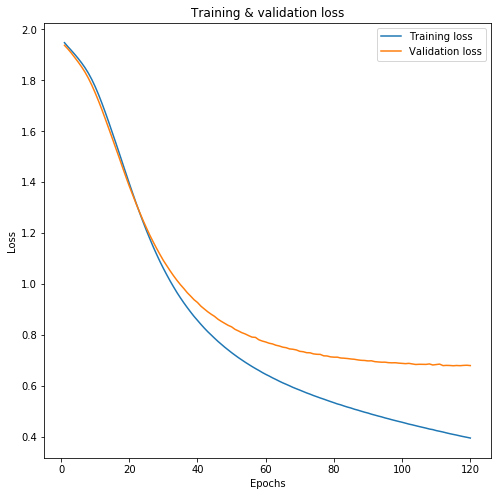

In [29]:
# Loss vs number of epochs with train and val set
fig, ax = plt.subplots(figsize=(8, 8))

loss_values = model_val_dict['loss']
val_loss_values = model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
ax.plot(epochs, loss_values, label='Training loss')
ax.plot(epochs, val_loss_values, label='Validation loss')

ax.set_title('Training & validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

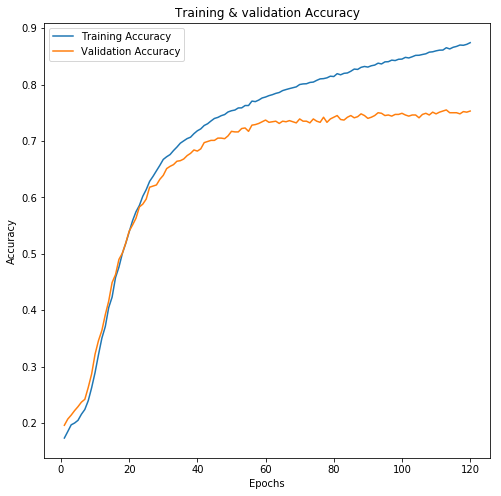

In [30]:
# Accuracy vs number of epochs with train and val set
fig, ax = plt.subplots(figsize=(8, 8))

acc_values = model_val_dict['accuracy']
val_acc_values = model_val_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training Accuracy')
ax.plot(epochs, val_acc_values, label='Validation Accuracy')

ax.set_title('Training & validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

Notice an interesting pattern here: although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss seem to be reaching a limit around the 60th epoch. This means that you're probably **overfitting** the model to the training data when you train for many epochs past this dropoff point of around 40 epochs. Luckily, you learned how to tackle overfitting in the previous lecture! Since it seems clear that you are training too long, include early stopping at the 60th epoch first.

## Early Stopping

Below, observe how to update the model to include an earlier cutoff point:

In [32]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(X_train_tokens,
                    y_train_lb,
                    epochs=60,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 6500 samples, validate on 1000 samples
Epoch 1/60
6500/6500 [==============================] - 1s 176us/step - loss: 1.9541 - accuracy: 0.1520 - val_loss: 1.9422 - val_accuracy: 0.1860
Epoch 2/60
6500/6500 [==============================] - 1s 139us/step - loss: 1.9243 - accuracy: 0.2003 - val_loss: 1.9211 - val_accuracy: 0.2140
Epoch 3/60
6500/6500 [==============================] - 1s 147us/step - loss: 1.9048 - accuracy: 0.2245 - val_loss: 1.9035 - val_accuracy: 0.2290
Epoch 4/60
6500/6500 [==============================] - 1s 139us/step - loss: 1.8865 - accuracy: 0.2354 - val_loss: 1.8863 - val_accuracy: 0.2380
Epoch 5/60
6500/6500 [==============================] - 1s 136us/step - loss: 1.8674 - accuracy: 0.2475 - val_loss: 1.8681 - val_accuracy: 0.2520
Epoch 6/60
6500/6500 [==============================] - 1s 146us/step - loss: 1.8460 - accuracy: 0.2600 - val_loss: 1.8473 - val_accuracy: 0.2660
Epoch 7/60
6500/6500 [==============================] - 1s 139us/step - loss

6500/6500 [==============================] - 1s 131us/step - loss: 0.6100 - accuracy: 0.7886 - val_loss: 0.7578 - val_accuracy: 0.7270
Epoch 57/60
6500/6500 [==============================] - 1s 160us/step - loss: 0.6040 - accuracy: 0.7903 - val_loss: 0.7551 - val_accuracy: 0.7180
Epoch 58/60
6500/6500 [==============================] - 1s 128us/step - loss: 0.5981 - accuracy: 0.7917 - val_loss: 0.7515 - val_accuracy: 0.7320
Epoch 59/60
6500/6500 [==============================] - 1s 131us/step - loss: 0.5922 - accuracy: 0.7954 - val_loss: 0.7504 - val_accuracy: 0.7320
Epoch 60/60
6500/6500 [==============================] - 1s 136us/step - loss: 0.5868 - accuracy: 0.7966 - val_loss: 0.7456 - val_accuracy: 0.7340


Now, you can use the test set to make label predictions

In [36]:
results_train = model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

6500/6500 [==============================] - 1s 167us/step
Training Loss: 0.581 Training Accuracy: 0.797
2500/2500 [==============================] - 0s 162us/step
Testing Loss: 0.719 Testing Accuracy: 0.736


We've significantly reduced the variance, so this is already pretty good! your test set accuracy is slightly worse, but this model will definitely be more robust than the 120 epochs model you originally fit.

Now, take a look at how regularization techniques can further improve your model performance.

## L2 Regularization

First, take a look at L2 regularization. Keras makes L2 regularization easy. Simply add the `kernel_regularizer=keras.regularizers.l2(lambda_coeff)` parameter to any model layer. The `lambda_coeff` parameter determines the strength of the regularization you wish to perform.

In [38]:
from keras import regularizers
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L2_model = model.fit(X_train_tokens,
                    y_train_lb,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 6500 samples, validate on 1000 samples
Epoch 1/120
6500/6500 [==============================] - 2s 266us/step - loss: 2.6117 - accuracy: 0.1455 - val_loss: 2.6005 - val_accuracy: 0.1360
Epoch 2/120
6500/6500 [==============================] - 1s 211us/step - loss: 2.5853 - accuracy: 0.1762 - val_loss: 2.5796 - val_accuracy: 0.1770
Epoch 3/120
6500/6500 [==============================] - 1s 165us/step - loss: 2.5669 - accuracy: 0.1977 - val_loss: 2.5622 - val_accuracy: 0.2060
Epoch 4/120
6500/6500 [==============================] - 1s 177us/step - loss: 2.5497 - accuracy: 0.2138 - val_loss: 2.5449 - val_accuracy: 0.2190
Epoch 5/120
6500/6500 [==============================] - 1s 145us/step - loss: 2.5314 - accuracy: 0.2308 - val_loss: 2.5269 - val_accuracy: 0.2370
Epoch 6/120
6500/6500 [==============================] - 1s 149us/step - loss: 2.5119 - accuracy: 0.2438 - val_loss: 2.5074 - val_accuracy: 0.2440
Epoch 7/120
6500/6500 [==============================] - 1s 141us/step

6500/6500 [==============================] - 1s 108us/step - loss: 1.2130 - accuracy: 0.7978 - val_loss: 1.3404 - val_accuracy: 0.7340
Epoch 57/120
6500/6500 [==============================] - 1s 105us/step - loss: 1.2043 - accuracy: 0.8000 - val_loss: 1.3338 - val_accuracy: 0.7340
Epoch 58/120
6500/6500 [==============================] - 1s 102us/step - loss: 1.1958 - accuracy: 0.8045 - val_loss: 1.3276 - val_accuracy: 0.7400
Epoch 59/120
6500/6500 [==============================] - 1s 101us/step - loss: 1.1877 - accuracy: 0.8054 - val_loss: 1.3225 - val_accuracy: 0.7470
Epoch 60/120
6500/6500 [==============================] - 1s 101us/step - loss: 1.1795 - accuracy: 0.8100 - val_loss: 1.3155 - val_accuracy: 0.7350
Epoch 61/120
6500/6500 [==============================] - 1s 99us/step - loss: 1.1718 - accuracy: 0.8138 - val_loss: 1.3125 - val_accuracy: 0.7390
Epoch 62/120
6500/6500 [==============================] - 1s 110us/step - loss: 1.1640 - accuracy: 0.8111 - val_loss: 1.3058 -

6500/6500 [==============================] - 1s 112us/step - loss: 0.9047 - accuracy: 0.8786 - val_loss: 1.1498 - val_accuracy: 0.7550
Epoch 112/120
6500/6500 [==============================] - 1s 107us/step - loss: 0.9008 - accuracy: 0.8786 - val_loss: 1.1500 - val_accuracy: 0.7570
Epoch 113/120
6500/6500 [==============================] - 1s 110us/step - loss: 0.8972 - accuracy: 0.8814 - val_loss: 1.1469 - val_accuracy: 0.7540
Epoch 114/120
6500/6500 [==============================] - 1s 108us/step - loss: 0.8931 - accuracy: 0.8811 - val_loss: 1.1438 - val_accuracy: 0.7570
Epoch 115/120
6500/6500 [==============================] - 1s 105us/step - loss: 0.8898 - accuracy: 0.8825 - val_loss: 1.1417 - val_accuracy: 0.7580
Epoch 116/120
6500/6500 [==============================] - 1s 108us/step - loss: 0.8859 - accuracy: 0.8838 - val_loss: 1.1401 - val_accuracy: 0.7570
Epoch 117/120
6500/6500 [==============================] - 1s 108us/step - loss: 0.8817 - accuracy: 0.8854 - val_loss: 1

In [39]:
L2_model_dict = L2_model.history
L2_model_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Now, look at the training accuracy as well as the validation accuracy for both the L2 and the model without regularization (for 120 epochs).

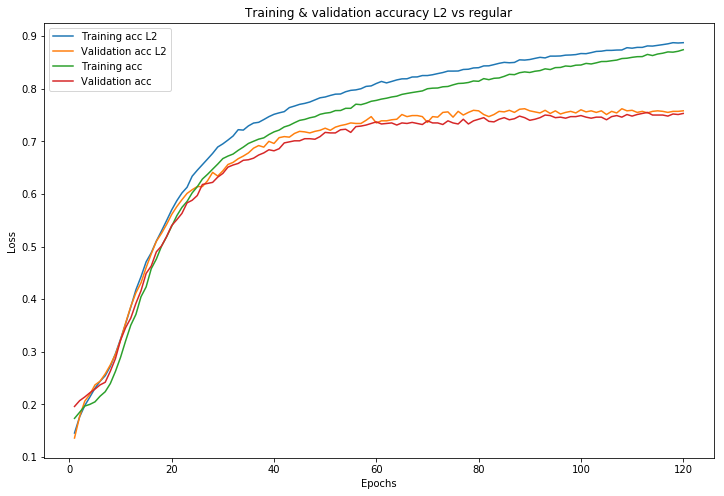

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = L2_model_dict['accuracy'] 
val_acc_values = L2_model_dict['val_accuracy']
model_acc = model_val_dict['accuracy']
model_val_acc = model_val_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L2')
ax.plot(epochs, val_acc_values, label='Validation acc L2')
ax.plot(epochs, model_acc, label='Training acc')
ax.plot(epochs, model_val_acc, label='Validation acc')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

The results of L2 regularization are quite disappointing here. Notice the discrepancy between validation and training accuracy seems to have decreased slightly, but the end result is definitely not getting better. 

## L1 Regularization

Have a look at L1 regularization. Will this work better?

In [41]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(X_train_tokens,
                    y_train_lb,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 6500 samples, validate on 1000 samples
Epoch 1/120
6500/6500 [==============================] - 1s 198us/step - loss: 16.0699 - accuracy: 0.1471 - val_loss: 15.7181 - val_accuracy: 0.1710
Epoch 2/120
6500/6500 [==============================] - 1s 144us/step - loss: 15.4117 - accuracy: 0.1746 - val_loss: 15.0720 - val_accuracy: 0.1780
Epoch 3/120
6500/6500 [==============================] - 1s 143us/step - loss: 14.7742 - accuracy: 0.1978 - val_loss: 14.4450 - val_accuracy: 0.2060
Epoch 4/120
6500/6500 [==============================] - 1s 140us/step - loss: 14.1544 - accuracy: 0.2125 - val_loss: 13.8343 - val_accuracy: 0.2240
Epoch 5/120
6500/6500 [==============================] - 1s 146us/step - loss: 13.5504 - accuracy: 0.2262 - val_loss: 13.2392 - val_accuracy: 0.2360
Epoch 6/120
6500/6500 [==============================] - 1s 136us/step - loss: 12.9620 - accuracy: 0.2415 - val_loss: 12.6593 - val_accuracy: 0.2420
Epoch 7/120
6500/6500 [==============================] - 1

Epoch 56/120
6500/6500 [==============================] - 1s 98us/step - loss: 1.9275 - accuracy: 0.6705 - val_loss: 1.9446 - val_accuracy: 0.6660
Epoch 57/120
6500/6500 [==============================] - 1s 100us/step - loss: 1.9153 - accuracy: 0.6722 - val_loss: 1.9333 - val_accuracy: 0.6670
Epoch 58/120
6500/6500 [==============================] - 1s 103us/step - loss: 1.9033 - accuracy: 0.6729 - val_loss: 1.9239 - val_accuracy: 0.6710
Epoch 59/120
6500/6500 [==============================] - 1s 110us/step - loss: 1.8919 - accuracy: 0.6754 - val_loss: 1.9113 - val_accuracy: 0.6700
Epoch 60/120
6500/6500 [==============================] - 1s 105us/step - loss: 1.8805 - accuracy: 0.6751 - val_loss: 1.9014 - val_accuracy: 0.6660
Epoch 61/120
6500/6500 [==============================] - 1s 105us/step - loss: 1.8694 - accuracy: 0.6772 - val_loss: 1.8903 - val_accuracy: 0.6690
Epoch 62/120
6500/6500 [==============================] - 1s 100us/step - loss: 1.8586 - accuracy: 0.6786 - val_l

6500/6500 [==============================] - 1s 114us/step - loss: 1.4661 - accuracy: 0.7025 - val_loss: 1.5102 - val_accuracy: 0.6830
Epoch 112/120
6500/6500 [==============================] - 1s 103us/step - loss: 1.4601 - accuracy: 0.7037 - val_loss: 1.5011 - val_accuracy: 0.6900
Epoch 113/120
6500/6500 [==============================] - 1s 115us/step - loss: 1.4538 - accuracy: 0.7051 - val_loss: 1.4985 - val_accuracy: 0.6930
Epoch 114/120
6500/6500 [==============================] - 1s 102us/step - loss: 1.4480 - accuracy: 0.7034 - val_loss: 1.4913 - val_accuracy: 0.6880
Epoch 115/120
6500/6500 [==============================] - 1s 112us/step - loss: 1.4427 - accuracy: 0.7034 - val_loss: 1.4846 - val_accuracy: 0.6920
Epoch 116/120
6500/6500 [==============================] - 1s 113us/step - loss: 1.4369 - accuracy: 0.7058 - val_loss: 1.4811 - val_accuracy: 0.6860
Epoch 117/120
6500/6500 [==============================] - 1s 108us/step - loss: 1.4310 - accuracy: 0.7058 - val_loss: 1

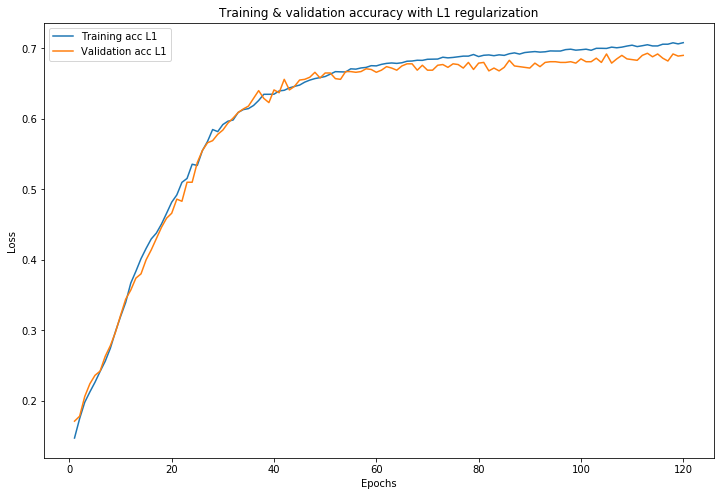

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model.history

acc_values = L1_model_dict['accuracy'] 
val_acc_values = L1_model_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy with L1 regularization')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

Notice how the training and validation accuracy don't diverge as much as before. Unfortunately, the validation accuracy doesn't reach rates much higher than 70%. It does seem like you can still improve the model by training much longer.

In [43]:
# ⏰ This cell may take several minutes to run
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(X_train_tokens,
                    y_train_lb,
                    epochs=1000,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 6500 samples, validate on 1000 samples
Epoch 1/1000
6500/6500 [==============================] - 2s 274us/step - loss: 16.0568 - accuracy: 0.1634 - val_loss: 15.7020 - val_accuracy: 0.1710
Epoch 2/1000
6500/6500 [==============================] - 1s 141us/step - loss: 15.3957 - accuracy: 0.1751 - val_loss: 15.0541 - val_accuracy: 0.1870
Epoch 3/1000
6500/6500 [==============================] - 1s 146us/step - loss: 14.7549 - accuracy: 0.1865 - val_loss: 14.4236 - val_accuracy: 0.1910
Epoch 4/1000
6500/6500 [==============================] - 1s 157us/step - loss: 14.1311 - accuracy: 0.2000 - val_loss: 13.8093 - val_accuracy: 0.2000
Epoch 5/1000
6500/6500 [==============================] - 1s 172us/step - loss: 13.5226 - accuracy: 0.2118 - val_loss: 13.2092 - val_accuracy: 0.2100
Epoch 6/1000
6500/6500 [==============================] - 1s 164us/step - loss: 12.9289 - accuracy: 0.2152 - val_loss: 12.6252 - val_accuracy: 0.2170
Epoch 7/1000
6500/6500 [============================

6500/6500 [==============================] - 1s 116us/step - loss: 1.8763 - accuracy: 0.6831 - val_loss: 1.9065 - val_accuracy: 0.6530
Epoch 56/1000
6500/6500 [==============================] - 1s 114us/step - loss: 1.8640 - accuracy: 0.6812 - val_loss: 1.8936 - val_accuracy: 0.6550
Epoch 57/1000
6500/6500 [==============================] - 1s 105us/step - loss: 1.8515 - accuracy: 0.6851 - val_loss: 1.8807 - val_accuracy: 0.6560
Epoch 58/1000
6500/6500 [==============================] - 1s 108us/step - loss: 1.8398 - accuracy: 0.6851 - val_loss: 1.8697 - val_accuracy: 0.6580
Epoch 59/1000
6500/6500 [==============================] - 1s 108us/step - loss: 1.8283 - accuracy: 0.6852 - val_loss: 1.8604 - val_accuracy: 0.6610
Epoch 60/1000
6500/6500 [==============================] - 1s 110us/step - loss: 1.8170 - accuracy: 0.6871 - val_loss: 1.8488 - val_accuracy: 0.6620
Epoch 61/1000
6500/6500 [==============================] - 1s 100us/step - loss: 1.8060 - accuracy: 0.6869 - val_loss: 1

6500/6500 [==============================] - 1s 104us/step - loss: 1.4545 - accuracy: 0.7086 - val_loss: 1.5004 - val_accuracy: 0.6900
Epoch 111/1000
6500/6500 [==============================] - 1s 108us/step - loss: 1.4487 - accuracy: 0.7091 - val_loss: 1.4979 - val_accuracy: 0.6910
Epoch 112/1000
6500/6500 [==============================] - 1s 108us/step - loss: 1.4437 - accuracy: 0.7089 - val_loss: 1.4896 - val_accuracy: 0.6970
Epoch 113/1000
6500/6500 [==============================] - 1s 114us/step - loss: 1.4384 - accuracy: 0.7108 - val_loss: 1.4862 - val_accuracy: 0.6950
Epoch 114/1000
6500/6500 [==============================] - 1s 106us/step - loss: 1.4337 - accuracy: 0.7106 - val_loss: 1.4811 - val_accuracy: 0.6970
Epoch 115/1000
6500/6500 [==============================] - 1s 103us/step - loss: 1.4289 - accuracy: 0.7108 - val_loss: 1.4765 - val_accuracy: 0.6930
Epoch 116/1000
6500/6500 [==============================] - 1s 102us/step - loss: 1.4241 - accuracy: 0.7109 - val_l

Epoch 165/1000
6500/6500 [==============================] - 1s 105us/step - loss: 1.2366 - accuracy: 0.7268 - val_loss: 1.2896 - val_accuracy: 0.7070
Epoch 166/1000
6500/6500 [==============================] - 1s 106us/step - loss: 1.2332 - accuracy: 0.7258 - val_loss: 1.2887 - val_accuracy: 0.7070
Epoch 167/1000
6500/6500 [==============================] - 1s 205us/step - loss: 1.2299 - accuracy: 0.7269 - val_loss: 1.2842 - val_accuracy: 0.7010
Epoch 168/1000
6500/6500 [==============================] - 1s 126us/step - loss: 1.2277 - accuracy: 0.7272 - val_loss: 1.2813 - val_accuracy: 0.7030
Epoch 169/1000
6500/6500 [==============================] - 1s 128us/step - loss: 1.2252 - accuracy: 0.7258 - val_loss: 1.2790 - val_accuracy: 0.7090
Epoch 170/1000
6500/6500 [==============================] - 1s 153us/step - loss: 1.2219 - accuracy: 0.7282 - val_loss: 1.2775 - val_accuracy: 0.7110
Epoch 171/1000
6500/6500 [==============================] - 1s 113us/step - loss: 1.2193 - accuracy:

6500/6500 [==============================] - 1s 109us/step - loss: 1.1274 - accuracy: 0.7382 - val_loss: 1.1910 - val_accuracy: 0.7160
Epoch 220/1000
6500/6500 [==============================] - 1s 110us/step - loss: 1.1266 - accuracy: 0.7372 - val_loss: 1.1876 - val_accuracy: 0.7180
Epoch 221/1000
6500/6500 [==============================] - 1s 108us/step - loss: 1.1246 - accuracy: 0.7382 - val_loss: 1.1842 - val_accuracy: 0.7150
Epoch 222/1000
6500/6500 [==============================] - 1s 109us/step - loss: 1.1235 - accuracy: 0.7374 - val_loss: 1.1913 - val_accuracy: 0.7150
Epoch 223/1000
6500/6500 [==============================] - 1s 105us/step - loss: 1.1221 - accuracy: 0.7372 - val_loss: 1.1856 - val_accuracy: 0.7220
Epoch 224/1000
6500/6500 [==============================] - 1s 107us/step - loss: 1.1216 - accuracy: 0.7386 - val_loss: 1.1825 - val_accuracy: 0.7160
Epoch 225/1000
6500/6500 [==============================] - 1s 103us/step - loss: 1.1196 - accuracy: 0.7392 - val_l

Epoch 274/1000
6500/6500 [==============================] - 1s 109us/step - loss: 1.0706 - accuracy: 0.7472 - val_loss: 1.1355 - val_accuracy: 0.7230
Epoch 275/1000
6500/6500 [==============================] - 1s 102us/step - loss: 1.0685 - accuracy: 0.7482 - val_loss: 1.1348 - val_accuracy: 0.7270
Epoch 276/1000
6500/6500 [==============================] - 1s 107us/step - loss: 1.0685 - accuracy: 0.7474 - val_loss: 1.1350 - val_accuracy: 0.7260
Epoch 277/1000
6500/6500 [==============================] - 1s 103us/step - loss: 1.0679 - accuracy: 0.7463 - val_loss: 1.1328 - val_accuracy: 0.7250
Epoch 278/1000
6500/6500 [==============================] - 1s 104us/step - loss: 1.0667 - accuracy: 0.7477 - val_loss: 1.1346 - val_accuracy: 0.7230
Epoch 279/1000
6500/6500 [==============================] - 1s 107us/step - loss: 1.0669 - accuracy: 0.7468 - val_loss: 1.1327 - val_accuracy: 0.7200
Epoch 280/1000
6500/6500 [==============================] - 1s 111us/step - loss: 1.0655 - accuracy:

6500/6500 [==============================] - 1s 105us/step - loss: 1.0275 - accuracy: 0.7575 - val_loss: 1.1010 - val_accuracy: 0.7300
Epoch 329/1000
6500/6500 [==============================] - 1s 104us/step - loss: 1.0269 - accuracy: 0.7569 - val_loss: 1.1030 - val_accuracy: 0.7330
Epoch 330/1000
6500/6500 [==============================] - 1s 113us/step - loss: 1.0259 - accuracy: 0.7563 - val_loss: 1.1008 - val_accuracy: 0.7330
Epoch 331/1000
6500/6500 [==============================] - 1s 105us/step - loss: 1.0254 - accuracy: 0.7548 - val_loss: 1.1102 - val_accuracy: 0.7350
Epoch 332/1000
6500/6500 [==============================] - 1s 119us/step - loss: 1.0249 - accuracy: 0.7562 - val_loss: 1.0977 - val_accuracy: 0.7310
Epoch 333/1000
6500/6500 [==============================] - 1s 117us/step - loss: 1.0241 - accuracy: 0.7582 - val_loss: 1.1069 - val_accuracy: 0.7310
Epoch 334/1000
6500/6500 [==============================] - 1s 105us/step - loss: 1.0241 - accuracy: 0.7554 - val_l

6500/6500 [==============================] - 1s 109us/step - loss: 0.9930 - accuracy: 0.7645 - val_loss: 1.0745 - val_accuracy: 0.7310
Epoch 383/1000
6500/6500 [==============================] - 1s 103us/step - loss: 0.9940 - accuracy: 0.7615 - val_loss: 1.0798 - val_accuracy: 0.7230
Epoch 384/1000
6500/6500 [==============================] - 1s 105us/step - loss: 0.9926 - accuracy: 0.7631 - val_loss: 1.0736 - val_accuracy: 0.7330
Epoch 385/1000
6500/6500 [==============================] - 1s 108us/step - loss: 0.9934 - accuracy: 0.7631 - val_loss: 1.0753 - val_accuracy: 0.7320
Epoch 386/1000
6500/6500 [==============================] - 1s 110us/step - loss: 0.9911 - accuracy: 0.7637 - val_loss: 1.0726 - val_accuracy: 0.7320
Epoch 387/1000
6500/6500 [==============================] - 1s 107us/step - loss: 0.9918 - accuracy: 0.7628 - val_loss: 1.0710 - val_accuracy: 0.7330
Epoch 388/1000
6500/6500 [==============================] - 1s 112us/step - loss: 0.9901 - accuracy: 0.7625 - val_l

Epoch 437/1000
6500/6500 [==============================] - 1s 105us/step - loss: 0.9657 - accuracy: 0.7720 - val_loss: 1.0547 - val_accuracy: 0.7410
Epoch 438/1000
6500/6500 [==============================] - 1s 108us/step - loss: 0.9667 - accuracy: 0.7686 - val_loss: 1.0479 - val_accuracy: 0.7380
Epoch 439/1000
6500/6500 [==============================] - 1s 105us/step - loss: 0.9659 - accuracy: 0.7703 - val_loss: 1.0523 - val_accuracy: 0.7340
Epoch 440/1000
6500/6500 [==============================] - 1s 108us/step - loss: 0.9651 - accuracy: 0.7717 - val_loss: 1.0566 - val_accuracy: 0.7380
Epoch 441/1000
6500/6500 [==============================] - 1s 148us/step - loss: 0.9637 - accuracy: 0.7702 - val_loss: 1.0515 - val_accuracy: 0.7320
Epoch 442/1000
6500/6500 [==============================] - 1s 117us/step - loss: 0.9652 - accuracy: 0.7686 - val_loss: 1.0513 - val_accuracy: 0.7410
Epoch 443/1000
6500/6500 [==============================] - 1s 108us/step - loss: 0.9628 - accuracy:

6500/6500 [==============================] - 1s 139us/step - loss: 0.9433 - accuracy: 0.7731 - val_loss: 1.0410 - val_accuracy: 0.7400
Epoch 492/1000
6500/6500 [==============================] - 1s 161us/step - loss: 0.9436 - accuracy: 0.7760 - val_loss: 1.0328 - val_accuracy: 0.7380
Epoch 493/1000
6500/6500 [==============================] - 1s 120us/step - loss: 0.9429 - accuracy: 0.7734 - val_loss: 1.0334 - val_accuracy: 0.7410
Epoch 494/1000
6500/6500 [==============================] - 1s 157us/step - loss: 0.9423 - accuracy: 0.7732 - val_loss: 1.0370 - val_accuracy: 0.7400
Epoch 495/1000
6500/6500 [==============================] - 1s 131us/step - loss: 0.9419 - accuracy: 0.7737 - val_loss: 1.0391 - val_accuracy: 0.7380
Epoch 496/1000
6500/6500 [==============================] - 1s 108us/step - loss: 0.9430 - accuracy: 0.7734 - val_loss: 1.0293 - val_accuracy: 0.7390
Epoch 497/1000
6500/6500 [==============================] - 1s 118us/step - loss: 0.9427 - accuracy: 0.7754 - val_l

6500/6500 [==============================] - 1s 122us/step - loss: 0.9263 - accuracy: 0.7783 - val_loss: 1.0205 - val_accuracy: 0.7430
Epoch 546/1000
6500/6500 [==============================] - 1s 104us/step - loss: 0.9250 - accuracy: 0.7820 - val_loss: 1.0288 - val_accuracy: 0.7450
Epoch 547/1000
6500/6500 [==============================] - 1s 103us/step - loss: 0.9236 - accuracy: 0.7782 - val_loss: 1.0248 - val_accuracy: 0.7440
Epoch 548/1000
6500/6500 [==============================] - 1s 110us/step - loss: 0.9247 - accuracy: 0.7798 - val_loss: 1.0250 - val_accuracy: 0.7370
Epoch 549/1000
6500/6500 [==============================] - 1s 115us/step - loss: 0.9242 - accuracy: 0.7809 - val_loss: 1.0191 - val_accuracy: 0.7460
Epoch 550/1000
6500/6500 [==============================] - 1s 113us/step - loss: 0.9248 - accuracy: 0.7800 - val_loss: 1.0208 - val_accuracy: 0.7480
Epoch 551/1000
6500/6500 [==============================] - 1s 118us/step - loss: 0.9236 - accuracy: 0.7808 - val_l

Epoch 600/1000
6500/6500 [==============================] - 1s 115us/step - loss: 0.9085 - accuracy: 0.7822 - val_loss: 1.0036 - val_accuracy: 0.7480
Epoch 601/1000
6500/6500 [==============================] - 1s 116us/step - loss: 0.9064 - accuracy: 0.7820 - val_loss: 1.0060 - val_accuracy: 0.7470
Epoch 602/1000
6500/6500 [==============================] - 1s 112us/step - loss: 0.9058 - accuracy: 0.7852 - val_loss: 1.0024 - val_accuracy: 0.7460
Epoch 603/1000
6500/6500 [==============================] - 1s 120us/step - loss: 0.9068 - accuracy: 0.7828 - val_loss: 1.0073 - val_accuracy: 0.7570
Epoch 604/1000
6500/6500 [==============================] - 1s 131us/step - loss: 0.9049 - accuracy: 0.7855 - val_loss: 1.0145 - val_accuracy: 0.7440
Epoch 605/1000
6500/6500 [==============================] - 1s 136us/step - loss: 0.9059 - accuracy: 0.7869 - val_loss: 1.0099 - val_accuracy: 0.7430
Epoch 606/1000
6500/6500 [==============================] - 1s 134us/step - loss: 0.9046 - accuracy:

6500/6500 [==============================] - 1s 133us/step - loss: 0.8916 - accuracy: 0.7911 - val_loss: 0.9930 - val_accuracy: 0.7490
Epoch 655/1000
6500/6500 [==============================] - 1s 141us/step - loss: 0.8923 - accuracy: 0.7886 - val_loss: 0.9941 - val_accuracy: 0.7510
Epoch 656/1000
6500/6500 [==============================] - 1s 147us/step - loss: 0.8915 - accuracy: 0.7889 - val_loss: 0.9928 - val_accuracy: 0.7460
Epoch 657/1000
6500/6500 [==============================] - 1s 116us/step - loss: 0.8907 - accuracy: 0.7885 - val_loss: 1.0369 - val_accuracy: 0.7300
Epoch 658/1000
6500/6500 [==============================] - 1s 132us/step - loss: 0.8913 - accuracy: 0.7895 - val_loss: 1.0236 - val_accuracy: 0.7470
Epoch 659/1000
6500/6500 [==============================] - 1s 119us/step - loss: 0.8922 - accuracy: 0.7877 - val_loss: 0.9929 - val_accuracy: 0.7470
Epoch 660/1000
6500/6500 [==============================] - 1s 124us/step - loss: 0.8903 - accuracy: 0.7869 - val_l

6500/6500 [==============================] - 1s 163us/step - loss: 0.8777 - accuracy: 0.7942 - val_loss: 0.9888 - val_accuracy: 0.7490
Epoch 709/1000
6500/6500 [==============================] - 1s 139us/step - loss: 0.8792 - accuracy: 0.7898 - val_loss: 0.9861 - val_accuracy: 0.7500
Epoch 710/1000
6500/6500 [==============================] - 1s 153us/step - loss: 0.8772 - accuracy: 0.7929 - val_loss: 0.9987 - val_accuracy: 0.7450
Epoch 711/1000
6500/6500 [==============================] - 1s 138us/step - loss: 0.8780 - accuracy: 0.7926 - val_loss: 1.0086 - val_accuracy: 0.7460
Epoch 712/1000
6500/6500 [==============================] - 1s 144us/step - loss: 0.8809 - accuracy: 0.7934 - val_loss: 1.0225 - val_accuracy: 0.7440
Epoch 713/1000
6500/6500 [==============================] - 1s 132us/step - loss: 0.8783 - accuracy: 0.7912 - val_loss: 0.9870 - val_accuracy: 0.7560
Epoch 714/1000
6500/6500 [==============================] - 1s 148us/step - loss: 0.8790 - accuracy: 0.7882 - val_l

6500/6500 [==============================] - 1s 115us/step - loss: 0.8644 - accuracy: 0.7945 - val_loss: 0.9995 - val_accuracy: 0.7520
Epoch 763/1000
6500/6500 [==============================] - 1s 118us/step - loss: 0.8631 - accuracy: 0.7969 - val_loss: 0.9804 - val_accuracy: 0.7530
Epoch 764/1000
6500/6500 [==============================] - 1s 120us/step - loss: 0.8638 - accuracy: 0.7949 - val_loss: 0.9749 - val_accuracy: 0.7520
Epoch 765/1000
6500/6500 [==============================] - 1s 121us/step - loss: 0.8625 - accuracy: 0.7960 - val_loss: 1.0014 - val_accuracy: 0.7370
Epoch 766/1000
6500/6500 [==============================] - 1s 120us/step - loss: 0.8635 - accuracy: 0.7983 - val_loss: 0.9803 - val_accuracy: 0.7470
Epoch 767/1000
6500/6500 [==============================] - 1s 123us/step - loss: 0.8647 - accuracy: 0.7943 - val_loss: 0.9822 - val_accuracy: 0.7480
Epoch 768/1000
6500/6500 [==============================] - 1s 123us/step - loss: 0.8672 - accuracy: 0.7928 - val_l

6500/6500 [==============================] - 1s 124us/step - loss: 0.8518 - accuracy: 0.7994 - val_loss: 0.9732 - val_accuracy: 0.7520
Epoch 817/1000
6500/6500 [==============================] - 1s 147us/step - loss: 0.8516 - accuracy: 0.7985 - val_loss: 0.9862 - val_accuracy: 0.7460
Epoch 818/1000
6500/6500 [==============================] - 1s 151us/step - loss: 0.8511 - accuracy: 0.7978 - val_loss: 0.9807 - val_accuracy: 0.7490
Epoch 819/1000
6500/6500 [==============================] - 1s 135us/step - loss: 0.8491 - accuracy: 0.8034 - val_loss: 0.9765 - val_accuracy: 0.7490
Epoch 820/1000
6500/6500 [==============================] - 1s 118us/step - loss: 0.8506 - accuracy: 0.8008 - val_loss: 0.9791 - val_accuracy: 0.7450
Epoch 821/1000
6500/6500 [==============================] - 1s 126us/step - loss: 0.8508 - accuracy: 0.7972 - val_loss: 0.9934 - val_accuracy: 0.7510
Epoch 822/1000
6500/6500 [==============================] - 1s 149us/step - loss: 0.8507 - accuracy: 0.8015 - val_l

6500/6500 [==============================] - 1s 118us/step - loss: 0.8425 - accuracy: 0.8037 - val_loss: 0.9642 - val_accuracy: 0.7510
Epoch 871/1000
6500/6500 [==============================] - 1s 115us/step - loss: 0.8400 - accuracy: 0.8022 - val_loss: 0.9704 - val_accuracy: 0.7560
Epoch 872/1000
6500/6500 [==============================] - 1s 146us/step - loss: 0.8399 - accuracy: 0.8018 - val_loss: 0.9697 - val_accuracy: 0.7480
Epoch 873/1000
6500/6500 [==============================] - 2s 274us/step - loss: 0.8438 - accuracy: 0.8015 - val_loss: 0.9768 - val_accuracy: 0.7540
Epoch 874/1000
6500/6500 [==============================] - 1s 180us/step - loss: 0.8389 - accuracy: 0.8034 - val_loss: 0.9788 - val_accuracy: 0.7510
Epoch 875/1000
6500/6500 [==============================] - 1s 164us/step - loss: 0.8395 - accuracy: 0.8046 - val_loss: 0.9660 - val_accuracy: 0.7500
Epoch 876/1000
6500/6500 [==============================] - 1s 118us/step - loss: 0.8411 - accuracy: 0.8043 - val_l

Epoch 925/1000
6500/6500 [==============================] - 1s 155us/step - loss: 0.8301 - accuracy: 0.8088 - val_loss: 0.9791 - val_accuracy: 0.7380
Epoch 926/1000
6500/6500 [==============================] - 1s 153us/step - loss: 0.8337 - accuracy: 0.8058 - val_loss: 0.9716 - val_accuracy: 0.7480
Epoch 927/1000
6500/6500 [==============================] - 1s 145us/step - loss: 0.8321 - accuracy: 0.8042 - val_loss: 0.9973 - val_accuracy: 0.7380
Epoch 928/1000
6500/6500 [==============================] - 1s 150us/step - loss: 0.8339 - accuracy: 0.8065 - val_loss: 0.9598 - val_accuracy: 0.7530
Epoch 929/1000
6500/6500 [==============================] - 1s 164us/step - loss: 0.8307 - accuracy: 0.8057 - val_loss: 0.9632 - val_accuracy: 0.7530
Epoch 930/1000
6500/6500 [==============================] - 1s 156us/step - loss: 0.8312 - accuracy: 0.8075 - val_loss: 0.9861 - val_accuracy: 0.7380
Epoch 931/1000
6500/6500 [==============================] - 1s 157us/step - loss: 0.8378 - accuracy:

6500/6500 [==============================] - 1s 117us/step - loss: 0.8223 - accuracy: 0.8125 - val_loss: 0.9894 - val_accuracy: 0.7390
Epoch 980/1000
6500/6500 [==============================] - 1s 118us/step - loss: 0.8262 - accuracy: 0.8066 - val_loss: 0.9627 - val_accuracy: 0.7530
Epoch 981/1000
6500/6500 [==============================] - 1s 137us/step - loss: 0.8200 - accuracy: 0.8135 - val_loss: 0.9889 - val_accuracy: 0.7370
Epoch 982/1000
6500/6500 [==============================] - 1s 124us/step - loss: 0.8293 - accuracy: 0.8065 - val_loss: 0.9885 - val_accuracy: 0.7400
Epoch 983/1000
6500/6500 [==============================] - 1s 125us/step - loss: 0.8223 - accuracy: 0.8112 - val_loss: 0.9652 - val_accuracy: 0.7550
Epoch 984/1000
6500/6500 [==============================] - 1s 115us/step - loss: 0.8214 - accuracy: 0.8120 - val_loss: 0.9601 - val_accuracy: 0.7480
Epoch 985/1000
6500/6500 [==============================] - 1s 121us/step - loss: 0.8219 - accuracy: 0.8111 - val_l

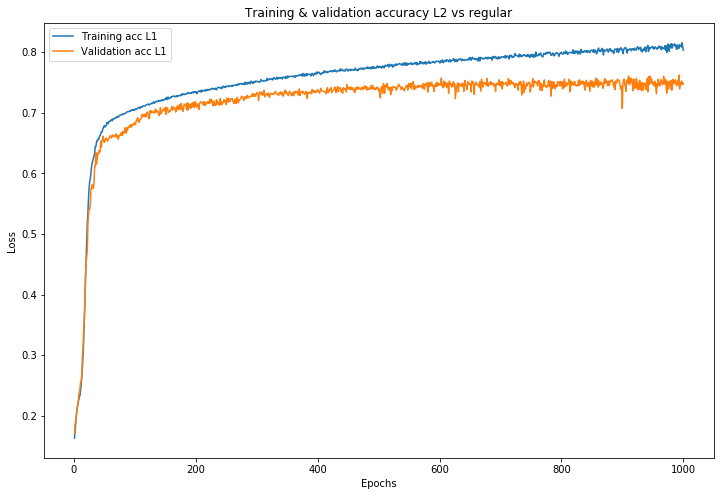

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model.history

acc_values = L1_model_dict['accuracy'] 
val_acc_values = L1_model_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

In [46]:
results_train = model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')   

6500/6500 [==============================] - 1s 205us/step
Training Loss: 0.825 Training Accuracy: 0.814
2500/2500 [==============================] - 1s 210us/step
Testing Loss: 0.957 Testing Accuracy: 0.767


This is about the best result you've achieved so far, but you were training for quite a while! Next, experiment with dropout regularization to see if it offers any advantages.

## Dropout Regularization

In [47]:
# ⏰ This cell may take about a minute to run
random.seed(123)
model = models.Sequential()
model.add(layers.Dropout(0.3, input_shape=(2000,)))
model.add(layers.Dense(50, activation='relu')) #2 hidden layers
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

dropout_model = model.fit(X_train_tokens,
                    y_train_lb,
                    epochs=200,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 6500 samples, validate on 1000 samples
Epoch 1/200
6500/6500 [==============================] - 3s 505us/step - loss: 2.0155 - accuracy: 0.1412 - val_loss: 1.9429 - val_accuracy: 0.1580
Epoch 2/200
6500/6500 [==============================] - 2s 317us/step - loss: 1.9639 - accuracy: 0.1542 - val_loss: 1.9231 - val_accuracy: 0.1780
Epoch 3/200
6500/6500 [==============================] - 2s 316us/step - loss: 1.9497 - accuracy: 0.1678 - val_loss: 1.9099 - val_accuracy: 0.2000
Epoch 4/200
6500/6500 [==============================] - 2s 291us/step - loss: 1.9250 - accuracy: 0.1854 - val_loss: 1.8986 - val_accuracy: 0.2130
Epoch 5/200
6500/6500 [==============================] - 2s 318us/step - loss: 1.9218 - accuracy: 0.1846 - val_loss: 1.8879 - val_accuracy: 0.2310
Epoch 6/200
6500/6500 [==============================] - 2s 305us/step - loss: 1.9067 - accuracy: 0.2029 - val_loss: 1.8766 - val_accuracy: 0.2440
Epoch 7/200
6500/6500 [==============================] - 3s 461us/step

6500/6500 [==============================] - 2s 288us/step - loss: 1.2489 - accuracy: 0.5262 - val_loss: 1.0360 - val_accuracy: 0.6650
Epoch 57/200
6500/6500 [==============================] - 2s 278us/step - loss: 1.2307 - accuracy: 0.5314 - val_loss: 1.0290 - val_accuracy: 0.6780
Epoch 58/200
6500/6500 [==============================] - 2s 286us/step - loss: 1.2167 - accuracy: 0.5443 - val_loss: 1.0167 - val_accuracy: 0.6730
Epoch 59/200
6500/6500 [==============================] - 2s 273us/step - loss: 1.2142 - accuracy: 0.5428 - val_loss: 1.0098 - val_accuracy: 0.6810
Epoch 60/200
6500/6500 [==============================] - 2s 280us/step - loss: 1.2003 - accuracy: 0.5438 - val_loss: 0.9994 - val_accuracy: 0.6920
Epoch 61/200
6500/6500 [==============================] - 2s 275us/step - loss: 1.1870 - accuracy: 0.5538 - val_loss: 0.9908 - val_accuracy: 0.6830
Epoch 62/200
6500/6500 [==============================] - 2s 277us/step - loss: 1.1987 - accuracy: 0.5465 - val_loss: 0.9862 

6500/6500 [==============================] - 2s 276us/step - loss: 0.9380 - accuracy: 0.6537 - val_loss: 0.7726 - val_accuracy: 0.7290
Epoch 112/200
6500/6500 [==============================] - 2s 348us/step - loss: 0.9521 - accuracy: 0.6472 - val_loss: 0.7709 - val_accuracy: 0.7310
Epoch 113/200
6500/6500 [==============================] - 2s 286us/step - loss: 0.9260 - accuracy: 0.6552 - val_loss: 0.7666 - val_accuracy: 0.7320
Epoch 114/200
6500/6500 [==============================] - 2s 291us/step - loss: 0.9315 - accuracy: 0.6565 - val_loss: 0.7648 - val_accuracy: 0.7310
Epoch 115/200
6500/6500 [==============================] - 2s 284us/step - loss: 0.9233 - accuracy: 0.6557 - val_loss: 0.7622 - val_accuracy: 0.7340
Epoch 116/200
6500/6500 [==============================] - 2s 293us/step - loss: 0.9257 - accuracy: 0.6569 - val_loss: 0.7578 - val_accuracy: 0.7370
Epoch 117/200
6500/6500 [==============================] - 2s 304us/step - loss: 0.9357 - accuracy: 0.6540 - val_loss: 0

C:\Users\alvar\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.114004). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


6500/6500 [==============================] - 3s 454us/step - loss: 0.8859 - accuracy: 0.6742 - val_loss: 0.7291 - val_accuracy: 0.7420
Epoch 135/200
6500/6500 [==============================] - 2s 266us/step - loss: 0.8789 - accuracy: 0.6737 - val_loss: 0.7279 - val_accuracy: 0.7430
Epoch 136/200
6500/6500 [==============================] - 2s 236us/step - loss: 0.8832 - accuracy: 0.6760 - val_loss: 0.7234 - val_accuracy: 0.7460
Epoch 137/200
6500/6500 [==============================] - 2s 233us/step - loss: 0.8712 - accuracy: 0.6855 - val_loss: 0.7223 - val_accuracy: 0.7460
Epoch 138/200
6500/6500 [==============================] - 2s 234us/step - loss: 0.8676 - accuracy: 0.6814 - val_loss: 0.7200 - val_accuracy: 0.7490
Epoch 139/200
6500/6500 [==============================] - 2s 305us/step - loss: 0.8611 - accuracy: 0.6837 - val_loss: 0.7199 - val_accuracy: 0.7470
Epoch 140/200
6500/6500 [==============================] - 2s 300us/step - loss: 0.8606 - accuracy: 0.6811 - val_loss: 0

6500/6500 [==============================] - 2s 233us/step - loss: 0.7773 - accuracy: 0.7088 - val_loss: 0.6620 - val_accuracy: 0.7640
Epoch 189/200
6500/6500 [==============================] - 1s 226us/step - loss: 0.7819 - accuracy: 0.7118 - val_loss: 0.6650 - val_accuracy: 0.7610
Epoch 190/200
6500/6500 [==============================] - 1s 226us/step - loss: 0.7842 - accuracy: 0.7029 - val_loss: 0.6641 - val_accuracy: 0.7620
Epoch 191/200
6500/6500 [==============================] - 1s 228us/step - loss: 0.7864 - accuracy: 0.7072 - val_loss: 0.6631 - val_accuracy: 0.7550
Epoch 192/200
6500/6500 [==============================] - 1s 226us/step - loss: 0.7690 - accuracy: 0.7155 - val_loss: 0.6627 - val_accuracy: 0.7660
Epoch 193/200
6500/6500 [==============================] - 1s 228us/step - loss: 0.7678 - accuracy: 0.7148 - val_loss: 0.6632 - val_accuracy: 0.7590
Epoch 194/200
6500/6500 [==============================] - 1s 223us/step - loss: 0.7626 - accuracy: 0.7188 - val_loss: 0

In [48]:
results_train = model.evaluate(X_train_tokens, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')   

6500/6500 [==============================] - 1s 151us/step
Training Loss: 0.468 Training Accuracy: 0.837
2500/2500 [==============================] - 0s 155us/step
Testing Loss: 0.639 Testing Accuracy: 0.764


You can see here that the validation performance has improved again! The variance did become higher again compared to L1-regularization.

## Bigger Data?

In the lecture, one of the solutions to high variance was just getting more data. You actually *have* more data, but took a subset of 10,000 units before. Let's now quadruple your data set, and see what happens. Note that you are really just lucky here, and getting more data isn't always possible, but this is a useful exercise in order to understand the power of big data sets.

In [49]:
df = pd.read_csv('Bank_complaints.csv')
df = df.sample(40000, random_state=123)

X = df["Consumer complaint narrative"]
y = df["Product"]

# train test split
X_train_lrg, X_test_lrg, y_train_lrg, y_test_lrg = train_test_split(X, y, random_state=42)

#Validation set
X_train_final_lrg, X_val_lrg, y_train_final_lrg, y_val_lrg = train_test_split(X_train_lrg, y_train_lrg, random_state=123)


#one-hot encoding of the complaints
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final_lrg)

X_train_tok_lrg = tokenizer.texts_to_matrix(X_train_final_lrg, mode='binary')
X_val_lrg = tokenizer.texts_to_matrix(X_val_lrg, mode='binary')
X_test_lrg = tokenizer.texts_to_matrix(X_test_lrg, mode='binary')

#one-hot encoding of products
lb = LabelBinarizer()
lb.fit(y_train_final_lrg)

y_train_lb_lrg = to_categorical(lb.transform(y_train_final_lrg))[:, :, 1]
y_val_lrg = to_categorical(lb.transform(y_val_lrg))[:, :, 1]
y_test_lrg = to_categorical(lb.transform(y_test_lrg))[:, :, 1]

In [50]:
# ⏰ This cell may take several minutes to run
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

moredata_model = model.fit(X_train_tok_lrg,
                    y_train_lb_lrg,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val_lrg, y_val_lrg))

Train on 22500 samples, validate on 7500 samples
Epoch 1/120
22500/22500 [==============================] - 4s 176us/step - loss: 1.9281 - accuracy: 0.1823 - val_loss: 1.8952 - val_accuracy: 0.2285
Epoch 2/120
22500/22500 [==============================] - 4s 156us/step - loss: 1.8586 - accuracy: 0.2491 - val_loss: 1.8162 - val_accuracy: 0.2859
Epoch 3/120
22500/22500 [==============================] - 3s 150us/step - loss: 1.7605 - accuracy: 0.3184 - val_loss: 1.7007 - val_accuracy: 0.3779
Epoch 4/120
22500/22500 [==============================] - 3s 149us/step - loss: 1.6302 - accuracy: 0.4143 - val_loss: 1.5597 - val_accuracy: 0.4679
Epoch 5/120
22500/22500 [==============================] - 3s 150us/step - loss: 1.4843 - accuracy: 0.5011 - val_loss: 1.4107 - val_accuracy: 0.5412
Epoch 6/120
22500/22500 [==============================] - 3s 136us/step - loss: 1.3383 - accuracy: 0.5708 - val_loss: 1.2706 - val_accuracy: 0.5916
Epoch 7/120
22500/22500 [==============================] 

22500/22500 [==============================] - 3s 113us/step - loss: 0.4409 - accuracy: 0.8462 - val_loss: 0.5736 - val_accuracy: 0.7905
Epoch 56/120
22500/22500 [==============================] - 3s 112us/step - loss: 0.4378 - accuracy: 0.8478 - val_loss: 0.5735 - val_accuracy: 0.7899
Epoch 57/120
22500/22500 [==============================] - 3s 111us/step - loss: 0.4348 - accuracy: 0.8487 - val_loss: 0.5734 - val_accuracy: 0.7925
Epoch 58/120
22500/22500 [==============================] - 3s 112us/step - loss: 0.4314 - accuracy: 0.8504 - val_loss: 0.5733 - val_accuracy: 0.7915
Epoch 59/120
22500/22500 [==============================] - 3s 114us/step - loss: 0.4287 - accuracy: 0.8509 - val_loss: 0.5723 - val_accuracy: 0.7901
Epoch 60/120
22500/22500 [==============================] - 3s 114us/step - loss: 0.4255 - accuracy: 0.8523 - val_loss: 0.5720 - val_accuracy: 0.7921
Epoch 61/120
22500/22500 [==============================] - 3s 114us/step - loss: 0.4226 - accuracy: 0.8523 - val

22500/22500 [==============================] - 3s 112us/step - loss: 0.3191 - accuracy: 0.8934 - val_loss: 0.5899 - val_accuracy: 0.8008
Epoch 110/120
22500/22500 [==============================] - 2s 110us/step - loss: 0.3177 - accuracy: 0.8934 - val_loss: 0.5919 - val_accuracy: 0.8013
Epoch 111/120
22500/22500 [==============================] - 3s 142us/step - loss: 0.3158 - accuracy: 0.8932 - val_loss: 0.5937 - val_accuracy: 0.8001
Epoch 112/120
22500/22500 [==============================] - 3s 112us/step - loss: 0.3140 - accuracy: 0.8956 - val_loss: 0.5972 - val_accuracy: 0.7995
Epoch 113/120
22500/22500 [==============================] - 2s 110us/step - loss: 0.3131 - accuracy: 0.8948 - val_loss: 0.5953 - val_accuracy: 0.8003
Epoch 114/120
22500/22500 [==============================] - 2s 110us/step - loss: 0.3109 - accuracy: 0.8957 - val_loss: 0.5976 - val_accuracy: 0.7981
Epoch 115/120
22500/22500 [==============================] - 2s 110us/step - loss: 0.3097 - accuracy: 0.8970

In [51]:
results_train = model.evaluate(X_train_tok_lrg, y_train_lb_lrg)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_lrg, y_test_lrg)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

22500/22500 [==============================] - 5s 225us/step
Training Loss: 0.298 Training Accuracy: 0.901
10000/10000 [==============================] - 2s 174us/step
Testing Loss: 0.61 Testing Accuracy: 0.791


With the same amount of epochs, you were able to get a fairly similar validation accuracy of 89.67 (compared to 88.45 in obtained in the first model in this lab). Your test set accuracy went up from 75.8 to 79.2% though, without any other regularization technique. You can still consider early stopping, L1, L2 and dropout here. It's clear that having more data has a strong impact on model performance!

## Additional Resources

* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb
* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
* https://catalog.data.gov/dataset/consumer-complaint-database

## Summary  

In this lesson, you not only built an initial deep-learning model, you then used a validation set to tune your model using various types of regularization.